In [33]:
import pickle
import numpy as np
import glob
import pickle
import matplotlib
import matplotlib.backends.backend_tkagg
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import random
import matplotlib.animation as animation
import scipy as scipy
from sklearn.cluster import KMeans

# ---- ALL HELPER FUNCTIONS GO BELOW -----

# Generates the hanning window 
def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    
    if len(varargin) == 1:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    if len(varargin) == 2: 
        N = varargin[0]
        K = varargin[1]
        Win = Win[:, None, None]                # shape (M, 1, 1)
        Win = np.broadcast_to(Win, (M, N, K))
    return Win

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def frameReshape(frame, numLoopsPerFrame, numRxAntennas):  #
    frameWithChirp = np.reshape(frame, (-1, numLoopsPerFrame, numRxAntennas), order='F')
    return frameWithChirp

# Modified this such that it expects (N x Nrx) size now instead of a 1D array of size N 
def get_RP(data, freq_min, freq_max, mCalData, nfft=2**8, fs=1e6, bg_sub=True, num_rx=4, num_tx=1):
    # data comes reshaped 

    # background subtraction
    if bg_sub:
        for i in range(4):
            data[:,:, i] = data[:, :, i] - data[:,0, i][:,None]
        # data = data - data[..., 0][:, :, None]

    # normalization
    # earlier: for each frame, normalize the data. Now I have to do that for each frame and each antenna 
    # earlier: 
    # for i in range(data.shape[1]):
        # data[:,i] = data[:,i] - data[:,i].mean()
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            data[:,i, j] = data[:,i, j] - data[:,i, j].mean()

    # hanning window used for getting RP 
    Win3D = hanning(data.shape[0], data.shape[1], data.shape[2])        # samples x frame_size x Rx_antennas (radar cube)
    data = data * mCalData
    RP = signal.zoom_fft(np.multiply(data, Win3D), fn=[freq_min,freq_max], m=nfft, axis=0, fs=fs)
    return RP

def get_RD(RP, nfft=2**8):
    # RP : (samples x frame_size) [old]
    # RP : (samples x frame_size x Rx_antennas) [new]
    # WinVel2D = hanning(int(frame_size), nfft)       # want to window on the doppler axis (chirps --> frame_size [256]) 
    # WinVel2D = WinVel2D.transpose()                 # hence the transpose 
    WinVel3D = hanning(RP.shape[1], RP.shape[0], RP.shape[2])   # frame_size x samples x Rx_antennas
    WinVel3D = WinVel3D.transpose(1, 0, 2)                      # samples x frame_size x Rx_antennas

    # getting RD
    RPExt = RP
    for i in range(RPExt.shape[2]):                                # loop over the antennas
        RPExt[:, :, i] = RPExt[:, :, i] - np.mean(RPExt[:, :, i], axis=1)[:,np.newaxis] 

    # np.multipy() --> element-wise multiplication
    RD = np.fft.fft(np.multiply(RPExt, WinVel3D), n=nfft, axis=1)
    RD = np.fft.fftshift(RD, axes=(1,))
    RD[:,116:140, :] = 0 # removing middle doppler noise
    return RD

def get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags):
    c = 2.98e8
    max_idxs = np.zeros(len(f_tags))
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        
        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)
    max_idxs = max_idxs.astype(int)
    kmeans = KMeans(n_clusters=2, n_init=10).fit(max_idxs.reshape(-1, 1))
    labels = kmeans.labels_
    majority_label = np.bincount(labels).argmax()
    majority_cluster = max_idxs[labels == majority_label]
    # print(majority_cluster)
    # target_idx = int(np.mean(max_idxs))
    # target_idx = int(np.mean(majority_cluster))
    target_idx = max_idxs[3]

    return target_idx, max_idxs

def angle_fft(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

# Template matching for sinc pattern in RD 
def generate_template(period, frame_size, f_tag, nfft=2**8, tag_duty_cycle=0.5):
    # period = Tc (chrip time)
    # frame size = Nc (#chirps in a frame)
    # nfft = 256 = Ns (number of samples, also the number of points in the FFT)

    # generating a time vector with values for each chirp (period)
    t = np.arange(0, period*frame_size, period)

    # generating a square wave during that time with the given duty cycle 
    sq_wav = signal.square(2*np.pi*f_tag*t, tag_duty_cycle)

    # the template is the FFT of the square wave
    sq_wav_fft = np.fft.fftshift(np.fft.fft(sq_wav, n=nfft, axis=0))
    return sq_wav_fft


def angle_fft_windowless(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx
    WinAng3D = np.ones_like(WinAng3D)       # just make it ones 

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

def find_doppler_bins(f_tags, doppler_freqs):
    search_f = np.concatenate((f_tags, -f_tags))
    bins = []

    for f in search_f: 
        err = np.abs(f - doppler_freqs)
        bins.append(np.argmin(err))

    bins_left = bins[len(f_tags):]
    bins_right = bins[:len(f_tags)]

    return bins_left, bins_right

def get_period(Igrid, Fgrid, n_frames):
    freqIndex = []
    for frameIdx in range(n_frames):
        Ipeaks, _ = signal.find_peaks((Igrid[:,frameIdx]))
        Fpeaks, _ = signal.find_peaks((Fgrid[:,frameIdx]))
        # print("peaks: " + str(Ipeaks))
        per1temp = np.diff(Ipeaks)
        per2temp = np.diff(Fpeaks)

        freqIndex.extend(per1temp)          # adds all elements of per1temp to freqIndex
        freqIndex.extend(per2temp)          # adds all elements of per2temp to freqIndex

    # Calculate period using a trimmed mean (similar to MATLAB's trimmean)
    if len(freqIndex) > 0:
        period = stats.trim_mean(freqIndex, 0.1)  # 10% trim on both ends (ignores extreme values)
    else:
        period = 0  # Handle case where no peaks are found
    return period                                 # just the mean of periods --> this should be okay 

# Unwrap phases and compute unwrapped distance
def unwrapPi(phases):
    # Custom phase unwrapping similar to MATLAB's unwrap with pi-periodicity
    return np.unwrap(phases, period=np.pi)

def get_displacement(Igrid, Qgrid, range_subset_width, n_frames):
    c = 2.98e8
    # phi = np.linspace(-np.pi/2, np.pi/2, 4001)  # (0 : pi/4000 : pi) -> 4001 points from 0 to pi
    phi = np.linspace(0, np.pi, 4001)
    # phi = np.linspace(-np.pi, np.pi, 8001)
    x = np.arange(0, range_subset_width)  # x = 1 : size(magFFTAll, 2)
    triWave = np.tile(signal.windows.triang(range_subset_width), (n_frames, 1))

    period = get_period(Igrid, Qgrid, n_frames)

    # Preallocate autocorrelation arrays
    autoCorr2a = np.zeros((n_frames, len(phi)))
    autoCorr2b = np.zeros((n_frames, len(phi)))
    for phiIdx, phiVal in enumerate(phi):
        # sinW = np.tile(np.abs(np.sin(2*x * np.pi / period + phiVal)), (n_frames, 1))                      # just repeats across frames
        # cosW = np.tile(np.abs(np.cos(2*x * np.pi / period + phiVal)), (n_frames, 1))

        sinW = np.tile(np.abs(np.sin(x * np.pi / period + phiVal)), (n_frames, 1))                      # just repeats across frames
        cosW = np.tile(np.abs(np.cos(x * np.pi / period + phiVal)), (n_frames, 1))


        # we are taking the sum along axis=1 (range_subset_width dimension) to calculate the correlation
        autoCorr2a[:, phiIdx] = np.sum(normalize(Igrid.transpose()) * sinW * triWave, axis=1)           # correlating I with sin
        autoCorr2b[:, phiIdx] = np.sum(normalize(Qgrid.transpose()) * cosW * triWave, axis=1)           # correlating Q with cos 
    autocorr = autoCorr2a + autoCorr2b
    # print(autocorr)
    # Find the index of the maximum correlation
    I = np.argmax(autocorr, axis=1)

    # Extract phases
    angles = phi[I]

    lam = c/(24.125e9)
    # for distance in m
    # return (lam / (4 * np.pi)) * unwrapPi(angles) 
    # return angles 
    return unwrapPi(angles)
    # return np.unwrap(angles, period=2*np.pi)

# Face-wise Phase extraction 
def get_phases(filename, n_frames, f_tags = np.array([156, 250, 313, 625]), sides=[0,1,2,3]):
    # data = pickle.load(open('/nas-data/soham/drone-landing/test_rotate-24GHz.pickle', 'rb'))
    data = pickle.load(open(filename, 'rb'))
    data_raw = data['Data']
    print(f"data_raw.shape = {data_raw.shape}")

    antenna_pick = 1
    nfft = 2**8
    fs = 1e6
    c = 2.98e8
    range_min = 0
    range_max = 5
    # f_tags = np.array([183, 337, 250, 127])
    # f_tags = np.array([156, 250, 313, 625])

    cfg = data['Cfg']
    CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
    frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
    N = cfg['N']  # Num samples per chirp
    chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
    period = cfg['Perd']
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c

    # Calculate range step
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope

    # Calibration calculations
    # -- N: number of samples (256)
    # -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
    rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
    mCalData = np.transpose(rep, (2, 1, 0))

    # n_frames = 160 

    # range_subset_width = 80 
    range_subset_width = 80
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    num_rx = 4
    num_tx = 1

    Igrid = np.zeros((4, range_subset_width, n_frames))
    Qgrid = np.zeros((4, range_subset_width, n_frames))
    Pgrid = np.zeros((4, range_subset_width, n_frames))
    dopgrid = np.zeros((nfft, num_rx))

    # side1 = 1
    # side2 = 3
    # side3 = 2
    # side4 = 0        

    side1 = sides[0]
    side2 = sides[1]
    side3 = sides[2]
    side4 = sides[3]

    binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

    mbl = [0,0,0,0]
    mbr = [0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]

    range_idxs = []
    range_idxs_A = []
    range_idxs_B = []
    range_idxs_C = []
    range_idxs_D = []
    # Do all this for a single frame
    for frame_no in range(0, n_frames):
        # print(f"Processing frame {frame_no}...")
        frame = data_raw[:, frame_no ,:]
        data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
        RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
        RD = get_RD(RP)        # 256 x 256 x 4 

        range_idx, max_idxs = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)
        # prevent range index spikes 
        if frame_no > 0 and np.abs(range_idx - range_idxs[-1]) > 3: 
            range_idx = range_idxs[-1]              # keep using the same range index 
        range_idxs.append(range_idx)
        range_idxs_A.append(max_idxs[0])
        range_idxs_B.append(max_idxs[1])
        range_idxs_C.append(max_idxs[2])
        range_idxs_D.append(max_idxs[3])
        # print(range_idx)
        
        # take for only one antenna for now 
        RD = RD[:, :, antenna_pick]

        for i in range(len(f_tags)):
            # Take the range subset for all angles 
            RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
            RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]     
            
            I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
            Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

            # Take the phase across the range subset 
            phase = np.atan(I_tag/Q_tag) 

            Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
            Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
            Pgrid[i][:, frame_no] = normalize(np.abs(phase))

    # phase values for each frequency
    phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
    phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
    phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
    phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D

    return phaseA, phaseB, phaseC, phaseD, range_idxs, range_idxs_A, range_idxs_B, range_idxs_C, range_idxs_D
    # return range_idxs

def generate_groundtruth_path_3d(coords, points_per_segment):
    """
    Generate a 3D groundtruth path from a list of 3D coordinates.

    Parameters
    ----------
    coords : array_like
        Sequence of (x, y, z) coordinates describing the path vertices.
        e.g. [(x0, y0, z0), (x1, y1, z1), (x2, y2, z2), ...]
        If you want a closed path, include the starting point again at the end.
    points_per_segment : int
        Number of interpolated points per segment between consecutive coordinates.

    Returns
    -------
    d : (N, 3) ndarray
        The concatenated (x, y, z) positions along the path.
    d_hat : (N, 3) ndarray
        Unit direction vectors from origin (0, 0, 0) to each point (i.e., tag origin → radar).
    """

    coords = np.asarray(coords, dtype=float)
    if coords.ndim != 2 or coords.shape[1] != 3:
        raise ValueError("coords must be an array of shape (M, 3)")

    segments = []
    for i in range(len(coords) - 1):
        start = coords[i]
        end = coords[i + 1]
        # Linear interpolation along x, y, z
        xs = np.linspace(start[0], end[0], points_per_segment)
        ys = np.linspace(start[1], end[1], points_per_segment)
        zs = np.linspace(start[2], end[2], points_per_segment)
        segments.append(np.column_stack((xs, ys, zs)))

    # Combine all segments into one path
    d = np.vstack(segments)
    # Normalize to get unit look vectors (tag origin -> radar)
    norms = np.linalg.norm(d, axis=1, keepdims=True)
    d_hat = d / norms
    return d, d_hat

def get_all_phases(filename, n_frames=None, f_tags = np.array([156, 250, 313, 625, 500]), sides=[0,1,2,3,4]):
    # data = pickle.load(open('/nas-data/soham/drone-landing/test_rotate-24GHz.pickle', 'rb'))
    data = pickle.load(open(filename, 'rb'))
    data_raw = data['Data']
    print(f"data_raw.shape = {data_raw.shape}")

    if n_frames == None:
        n_frames = data_raw.shape[1] - 1

    antenna_pick = 1
    nfft = 2**8
    fs = 1e6
    c = 2.98e8
    range_min = 0
    range_max = 5
    # f_tags = np.array([183, 337, 250, 127])
    # f_tags = np.array([156, 250, 313, 625])

    cfg = data['Cfg']
    CalDat = data['CalDat'][4:]         # doesn't change much whether I take the firs 4 or the last 4 (which 4 to take?)
    frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
    N = cfg['N']  # Num samples per chirp
    chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
    period = cfg['Perd']
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c

    # Calculate range step
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope

    # Calibration calculations
    # -- N: number of samples (256)
    # -- Cfg['FrmMeasSiz]: Number of chirps in one frame (128)
    rep = np.tile(CalDat[:, None, None], (1, cfg['FrmMeasSiz'], N))    # repeats CalDat along axis 2 and 3 with sizes #chirps, #samples 
    mCalData = np.transpose(rep, (2, 1, 0))

    # n_frames = 160 

    # range_subset_width = 80 
    range_subset_width = 60
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    num_rx = 4
    num_tx = 1

    Igrid = np.zeros((5, range_subset_width, n_frames))
    Qgrid = np.zeros((5, range_subset_width, n_frames))
    Pgrid = np.zeros((5, range_subset_width, n_frames))
    dopgrid = np.zeros((nfft, num_rx))

    # side1 = 1
    # side2 = 3
    # side3 = 2
    # side4 = 0        

    side1 = sides[0]
    side2 = sides[1]
    side3 = sides[2]
    side4 = sides[3]
    side5 = sides[4]

    binsleft, binsright = find_doppler_bins(f_tags, doppler_freqs)

    mbl = [0,0,0,0,0]
    mbr = [0,0,0,0,0]
    mbl[0] = binsleft[side1]
    mbr[0] = binsright[side1]
    mbl[1] = binsleft[side2]
    mbr[1] = binsright[side2]
    mbl[2] = binsleft[side3]
    mbr[2] = binsright[side3]
    mbl[3] = binsleft[side4]
    mbr[3] = binsright[side4]
    mbl[4] = binsleft[side5]
    mbr[4] = binsright[side5]

    range_idxs = []
    range_idxs_A = []
    range_idxs_B = []
    range_idxs_C = []
    range_idxs_D = []
    range_idxs_E = []
    # Do all this for a single frame
    for frame_no in range(0, n_frames):
        # print(f"Processing frame {frame_no}...")
        frame = data_raw[:, frame_no ,:]
        data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
        RP = get_RP(data_frame_reshaped, freq_min, freq_max, mCalData=mCalData)
        RD = get_RD(RP)        # 256 x 256 x 4 

        range_idx, max_idxs = get_target_range_idx(RD, freq_max, freq_min, chirp_slope, period, nfft, frame_size, f_tags)
        # prevent range index spikes 
        if frame_no > 0 and np.abs(range_idx - range_idxs[-1]) > 3: 
            range_idx = range_idxs[-1]              # keep using the same range index 
        range_idxs.append(range_idx)
        range_idxs_A.append(max_idxs[0])
        range_idxs_B.append(max_idxs[1])
        range_idxs_C.append(max_idxs[2])
        range_idxs_D.append(max_idxs[3])
        range_idxs_E.append(max_idxs[4])
        # print(range_idx)
        
        # take for only one antenna for now 
        RD = RD[:, :, antenna_pick]

        for i in range(len(f_tags)):
            # print(max_idxs[i])
            # Take the range subset for all angles 
            RD_bins_left = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbl[i]]     # range subset x doppler index x all angles 
            RD_bins_right = RD[range_idx - int(range_subset_width/2) : range_idx + int(range_subset_width/2), mbr[i]]     
            
            I_tag = (RD_bins_right + np.conjugate(RD_bins_left))/2
            Q_tag = (RD_bins_right - np.conjugate(RD_bins_left))*1j/2

            # Take the phase across the range subset 
            phase = np.atan(I_tag/Q_tag) 

            Igrid[i][:, frame_no] = normalize(np.abs((I_tag)))
            Qgrid[i][:, frame_no] = normalize(np.abs((Q_tag)))
            Pgrid[i][:, frame_no] = normalize(np.abs(phase))

    # phase values for each frequency
    phaseA = get_displacement(Igrid[0], Qgrid[0], range_subset_width, n_frames)          # face A
    phaseB = get_displacement(Igrid[1], Qgrid[1], range_subset_width, n_frames)          # face B 
    phaseC = get_displacement(Igrid[2], Qgrid[2], range_subset_width, n_frames)          # face C
    phaseD = get_displacement(Igrid[3], Qgrid[3], range_subset_width, n_frames)          # face D
    phaseE = get_displacement(Igrid[4], Qgrid[4], range_subset_width, n_frames)          # face E

    # idxD = np.asarray(range_idxs_D, dtype=float)
    # rangeD = (c / (2 * chirp_slope)) * (idxD * fs / nfft)

    return phaseA, phaseB, phaseC, phaseD, phaseE, range_steps[np.array(range_idxs)]

In [7]:
import numpy as np


# Automatic flipping of phase if measured does not match groundtruth.
# SHOULD NOT INCLUDE THIS IN FINAL DATA!!! This requies groundtruth data to work so would not be applicable
# to a "real" system. 
def flip_phase(measured_list, truth_list, metric="rmse"):
    """
    For each (measured, truth) pair, compute error for +measured and -measured,
    then return the version with lower error.

    Args:
        measured_list: list[np.ndarray]  measured phase arrays
        truth_list:    list[np.ndarray]  groundtruth phase arrays (same lengths or longer)
        metric:        "rmse" or "mae"

    Returns:
        out_list:   list[np.ndarray]    chosen arrays (some may be flipped)
        signs:      list[int]           +1 where kept, -1 where flipped
        errors:     list[tuple]         (err_pos, err_neg) per series (for diagnostics)
    """
    def err(a, b):
        a, b = np.asarray(a), np.asarray(b)
        n = min(a.size, b.size)  # safe if lengths differ
        a, b = a[:n], b[:n]
        if metric == "mae":
            return float(np.nanmean(np.abs(a - b)))
        # default RMSE
        return float(np.sqrt(np.nanmean((a - b)**2)))

    out_list, signs, errors = [], [], []
    for meas, truth in zip(measured_list, truth_list):
        e_pos = err(meas, truth)
        e_neg = err(-meas, truth)
        if e_neg < e_pos:
            out_list.append(-meas)
            signs.append(-1)
        else:
            out_list.append(meas)
            signs.append(+1)
        errors.append((e_pos, e_neg))
    return out_list, signs, errors

In [38]:
import pickle
import numpy as np
import pandas as pd

# ---------------------------
# Quaternion / rotation utils
# ---------------------------
def _quat_to_R(x, y, z, w):
    """Return 3x3 rotation matrix from quaternion (x, y, z, w)."""
    q = np.array([x, y, z, w], dtype=float)
    n = np.linalg.norm(q)
    if n == 0:
        return np.eye(3)
    x, y, z, w = q / n
    xx, yy, zz = x*x, y*y, z*z
    xy, xz, yz = x*y, x*z, y*z
    wx, wy, wz = w*x, w*y, w*z
    return np.array([
        [1 - 2*(yy + zz),     2*(xy - wz),       2*(xz + wy)],
        [    2*(xy + wz),  1 - 2*(xx + zz),      2*(yz - wx)],
        [    2*(xz - wy),     2*(yz + wx),   1 - 2*(xx + yy)]
    ], dtype=float)

_TS_MULT = {"ns": 1, "us": 1_000, "ms": 1_000_000, "s": 1_000_000_000}

def _to_ns(series: pd.Series, unit: str = "ms") -> np.ndarray:
    unit = unit.lower()
    if unit not in _TS_MULT:
        raise ValueError(f"Unsupported vicon_ts_unit: {unit}")
    return np.round(series.to_numpy(dtype=float) * _TS_MULT[unit]).astype(np.int64)

# -----------------------------------------------
# Read Vicon, compute d / d_hat in TAG coordinates
# -----------------------------------------------
def _read_vicon_tag_frame_d(
    csv_path: str,
    drone_subject: str,
    tag_subject: str,
    vicon_ts_unit: str = "ms",
    scale: float = 1e-3,              # mm -> m (set 1.0 to keep original units)
    radar_offset_drone=(0.0, 0.0, 0.0)  # (dx,dy,dz) in DRONE/BODY frame, same units as positions
):
    """
    Returns per-Vicon-frame groundtruth in TAG FRAME:
      d_tag:        (N,3) tag->radar vector in tag coords
      d_hat_tag:    (N,3) unit vectors of d_tag
      ts_vicon_ns:  (N,)  int64 timestamps (ns) per kept frame (sorted)
    """
    usecols = ["timestamp","frame","subject","x","y","z","qx","qy","qz","qw"]
    df = pd.read_csv(csv_path, usecols=usecols)

    # Keep only the two subjects
    df = df[df["subject"].isin([drone_subject, tag_subject])]

    # Drop rows where position is all zeros
    df = df[~((df["x"] == 0) & (df["y"] == 0) & (df["z"] == 0))]

    # Drop NaN positions or quaternions
    df = df.dropna(subset=["x","y","z","qx","qy","qz","qw"])

    # Keep the latest observation per (frame, subject)
    df = df.sort_values(["frame","subject","timestamp"]).drop_duplicates(
        subset=["frame","subject"], keep="last"
    )

    # Convert timestamps to ns
    df["ts_ns"] = _to_ns(df["timestamp"], vicon_ts_unit)

    # Pivot to one row per frame with both subjects' pose
    wide = df.pivot(index="frame", columns="subject",
                    values=["x","y","z","qx","qy","qz","qw","ts_ns"])

    needed = [(k,s) for k in ["x","y","z","qx","qy","qz","qw","ts_ns"]
                    for s in [drone_subject, tag_subject]]
    wide = wide.reindex(columns=pd.MultiIndex.from_tuples(needed)).dropna()

    # Extract positions (world) and quaternions
    def _col(k, s): return wide[(k, s)].to_numpy(dtype=float)

    p_d = np.column_stack([_col("x",drone_subject), _col("y",drone_subject), _col("z",drone_subject)])
    p_t = np.column_stack([_col("x",tag_subject),   _col("y",tag_subject),   _col("z",tag_subject)])

    qd = np.column_stack([_col("qx",drone_subject), _col("qy",drone_subject),
                          _col("qz",drone_subject), _col("qw",drone_subject)])
    qt = np.column_stack([_col("qx",tag_subject),   _col("qy",tag_subject),
                          _col("qz",tag_subject),   _col("qw",tag_subject)])

    ts_dr = _col("ts_ns", drone_subject).astype(np.int64)
    ts_tg = _col("ts_ns", tag_subject).astype(np.int64)
    ts_v  = np.maximum(ts_dr, ts_tg)

    # Convert units
    if scale != 1.0:
        p_d *= scale
        p_t *= scale
    radar_off = np.asarray(radar_offset_drone, dtype=float)
    if scale != 1.0:
        radar_off = radar_off * scale

    # Build rotation matrices per frame, compute radar position in world
    N = len(wide)
    d_tag = np.zeros((N,3), dtype=float)

    for i in range(N):
        Rd = _quat_to_R(qd[i,0], qd[i,1], qd[i,2], qd[i,3])  # subject->world (body to world)
        Rt = _quat_to_R(qt[i,0], qt[i,1], qt[i,2], qt[i,3])  # tag->world

        radar_world = p_d[i] + Rd @ radar_off          # translate offset from drone frame to world
        rel_world   = radar_world - p_t[i]             # vector from tag origin to radar, in world
        d_tag[i]    = Rt.T @ rel_world                 # express in TAG frame (world->tag)

    # Normalize
    norms = np.linalg.norm(d_tag, axis=1, keepdims=True)
    d_hat_tag = np.zeros_like(d_tag)
    nz = norms.squeeze() > 0
    d_hat_tag[nz] = d_tag[nz] / norms[nz]

    # Sort by time
    order = np.argsort(ts_v)
    return d_tag[order], d_hat_tag[order], ts_v[order]

# -----------------------------------------
# Select first Vicon frame AFTER each radar
# -----------------------------------------
def process_vicon(
    radar_pickle_path: str,
    vicon_csv_path: str,
    drone_subject: str = "mavic",
    tag_subject: str = "tag",
    vicon_ts_unit: str = "ms",
    scale: float = 1e-3,
    radar_offset_drone=(0.0, 0.0, 0.0),  # in DRONE frame (e.g., camera/radar below drone: (0,0,-0.07))
):
    """
    Load radar pickle, compute groundtruth d/d_hat in TAG frame (with radar offset),
    and for each radar timestamp pick the first Vicon frame strictly AFTER it.

    Returns
    -------
    d_sel      : (K,3) tag->radar in TAG coords
    d_hat_sel  : (K,3) unit vectors in TAG coords
    radar_idx  : (K,)  indices of radar frames that found a following Vicon frame
    vicon_idx  : (K,)  indices into the sorted Vicon arrays
    """
    # Load radar timestamps (ns)
    with open(radar_pickle_path, "rb") as f:
        radar_data = pickle.load(f)
    radar_ts = np.asarray(radar_data["dtime"], dtype=np.int64)

    # Vicon → tag-frame groundtruth
    d_v, d_hat_v, ts_v = _read_vicon_tag_frame_d(
        vicon_csv_path,
        drone_subject=drone_subject,
        tag_subject=tag_subject,
        vicon_ts_unit=vicon_ts_unit,
        scale=scale,
        radar_offset_drone=radar_offset_drone,
    )

    # First Vicon strictly after each radar ts
    j = np.searchsorted(ts_v, radar_ts, side="right")
    keep = j < len(ts_v)
    radar_idx = np.nonzero(keep)[0]
    vicon_idx = j[keep]

    d_sel = d_v[vicon_idx]
    d_hat_sel = d_hat_v[vicon_idx]
    return d_sel, d_hat_sel, radar_idx, vicon_idx

# -----------------
# Example usage
# -----------------
# radar_pkl = "radar_capture.pkl"
# vicon_csv = "vicon_log.csv"
# # Example: radar is 7 cm below the drone center (in drone frame z is up)
# d, d_hat, kept_radar_idx, used_vicon_idx = vicon_tagframe_after_radar(
#     radar_pkl, vicon_csv,
#     drone_subject="mavic_mount_2",   # or "mavic"
#     tag_subject="box",               # or "tag"
#     vicon_ts_unit="ms",
#     scale=1e-3,                      # mm -> m
#     radar_offset_drone=(0.0, 0.0, -0.07),
# )
# print(d.shape, d_hat.shape)


[[ 3.00034505e-02 -1.14012880e-03  8.83494022e-01]
 [ 2.93783478e-02 -8.18652881e-04  8.83310870e-01]
 [ 2.92066032e-02 -6.63314594e-04  8.83227543e-01]
 ...
 [ 4.00245002e-02 -4.03429328e-02  8.64629788e-01]
 [ 4.00095000e-02 -4.03644284e-02  8.64622542e-01]
 [ 3.99693208e-02 -4.04204992e-02  8.64604587e-01]]
Matched 262 of 262 radar frames to Vicon data.


Text(0, 0.5, 'Phase [rad]')

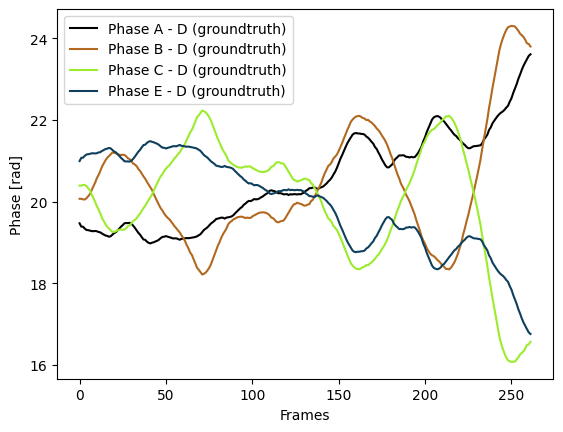

In [32]:
# Testing CSV data tracking

d, dhat, _, _ = load_radar_and_align_vicon("irl_drone_hover_1-24GHz.pickle", "irl_drone_hover_1.csv")

lam = 3e8/24.15e9
norms = np.linalg.norm(d, axis=1)
vhat = d / norms[:, None]             # tag-origin -> radar

## NEW TAG!!!!
a = np.array((0.0, 0.07, -0.020))    # face A (w.r.t. front-face origin) 
b = np.array((-0.072, 0.0, -0.02)) 
c = np.array((0.072, 0.0, -0.02))     # face B
e = np.array((0.0, -0.07, -0.020)) 

# projections
dr_a = vhat @ a
dr_b = vhat @ b
dr_c = vhat @ c
dr_e = vhat @ e

# Round-trip phase
dphi_a = -(4*np.pi/lam) * dr_a
dphi_b = -(4*np.pi/lam) * dr_b
dphi_c = -(4*np.pi/lam) * dr_c
dphi_e = -(4*np.pi/lam) * dr_e

plt.plot(dphi_a, label="Phase A - D (groundtruth)", color="#000000")
plt.plot(dphi_b, label="Phase B - D (groundtruth)", color="#B2691F")
plt.plot(dphi_c, label="Phase C - D (groundtruth)", color="#9CEB2D")
plt.plot(dphi_e, label="Phase E - D (groundtruth)", color="#0E3F5C")
plt.legend(); plt.xlabel("Frames"); plt.ylabel("Phase [rad]")

In [10]:
from scipy.optimize import minimize


a = (0, 0.065, -0.028)                            
b = (-0.04, 0, -0.02)                             
c = (0.04, 0, -0.02)
old_tag = (a, b, c)

## NEW TAG!!!!
a = np.array((0.0, 0.07, -0.020))    # face A (w.r.t. front-face origin) 
b = np.array((-0.072, 0.0, -0.02)) 
c = np.array((0.072, 0.0, -0.02))     # face B
e = np.array((0.0, -0.07, -0.020)) 

new_tag = (a, b, c, e)



def full_processing(filename, n_frames, tag, groundtruth_points, frames_per_seg, initial_guess=[np.pi/2, np.pi/2]):



    phaseA, phaseB, phaseC, phaseD, phaseE, ranges = get_all_phases(filename, n_frames)
    plt.figure()
    plt.plot(phaseA, label="Phase of face A", color="#fc1703")
    plt.plot(phaseB, label="Phase of face B", color="#13294B")
    plt.plot(phaseC, label="Phase of face C", color="#FF5F05")
    plt.plot(phaseD, label="Phase of face D", color="#006230")
    plt.plot(phaseE, label="Phase of face E", color="#5C0E41")
    plt.legend()
    plt.xlabel("Frames")
    plt.ylabel("Phase values")
    plt.tight_layout()


    phaseAD = phaseA - phaseD 
    phaseBD = phaseB - phaseD
    phaseCD = phaseC - phaseD
    phaseED = phaseE - phaseD 
    plt.figure()
    plt.plot(phaseAD, label="Phase A - D (measured)", color="#fc1703")
    plt.plot(phaseBD, label="Phase B - D (measured)", color="#5372A1")
    plt.plot(phaseCD, label="Phase C - D (measured)", color="#FF5F05")
    plt.plot(phaseED, label="Phase E - D (measured)", color="#5C0E41")
    plt.legend(); plt.xlabel("Frames"); plt.ylabel("Phase [rad]"); plt.tight_layout()

    # Unwrapping a 2nd time eliminates potential "jumps" in the phase difference data.
    phaseAD = np.unwrap(phaseAD, period=np.pi)
    phaseBD = np.unwrap(phaseBD, period=np.pi)
    phaseCD = np.unwrap(phaseCD, period=np.pi)
    phaseED = np.unwrap(phaseED, period=np.pi)
    plt.figure()
    plt.plot(phaseAD, label="Phase A - D (unwrapped)", color="#fc1703")
    plt.plot(phaseBD, label="Phase B - D (unwrapped)", color="#5372A1")
    plt.plot(phaseCD, label="Phase C - D (uwrapped)", color="#FF5F05")
    plt.plot(phaseED, label="Phase E - D (unwrapped)", color="#5C0E41")
    plt.legend(); plt.xlabel("Frames"); plt.ylabel("Phase [rad]"); plt.tight_layout()

    # points = [ (0, 0, 1.88), (0.1, 0, 1.88), (0.1, 0.1, 1.88) ]

    d, dhat = generate_groundtruth_path_3d(groundtruth_points, frames_per_seg)

    lam = 3e8/24.15e9
    norms = np.linalg.norm(d, axis=1)
    vhat = d / norms[:, None]             # tag-origin -> radar

    ## NEW TAG!!!!
    # a = np.array((0.0, 0.07, -0.020))    # face A (w.r.t. front-face origin) 
    # b = np.array((-0.072, 0.0, -0.02)) 
    # c = np.array((0.072, 0.0, -0.02))     # face B
    # e = np.array((0.0, -0.07, -0.020)) 
    a = tag[0]    # face A (w.r.t. front-face origin) 
    b = tag[1]
    c = tag[2]    # face B
    e = tag[3] 

    # projections
    dr_a = vhat @ a
    dr_b = vhat @ b
    dr_c = vhat @ c
    dr_e = vhat @ e

    # Round-trip phase
    dphi_a = -(4*np.pi/lam) * dr_a
    dphi_b = -(4*np.pi/lam) * dr_b
    dphi_c = -(4*np.pi/lam) * dr_c
    dphi_e = -(4*np.pi/lam) * dr_e

    # Assume we know the starting position of the radar. Given this, we can shift each phase difference by the starting amount
    phaseAD = phaseAD + (dphi_a[0] - phaseAD[0])
    phaseBD = phaseBD + (dphi_b[0] - phaseBD[0])
    phaseCD = phaseCD + (dphi_c[0] - phaseCD[0])
    phaseED = phaseED + (dphi_e[0] - phaseED[0])

    # Auto-fix mirroring issue (FIX ME!!!!!)
    [phaseAD, phaseBD, phaseCD, phaseED], signs, errs = flip_phase(
        [phaseAD, phaseBD, phaseCD, phaseED],
        [dphi_a, dphi_b, dphi_c, dphi_e],
        metric="rmse",  # or "mae"
    )

    plt.figure()
    plt.plot(dphi_a, label="Phase A - D (groundtruth)", color="#707372")
    plt.plot(dphi_b, label="Phase B - D (groundtruth)", color="#B2691F")
    plt.plot(dphi_c, label="Phase C - D (groundtruth)", color="#527225")
    plt.plot(dphi_e, label="Phase E - D (groundtruth)", color="#0E3F5C")
    plt.plot(phaseAD, label="Phase A - D (measured & processed)", color="#fc1703")
    plt.plot(phaseBD, label="Phase B - D (measured & processed)", color="#5372A1")
    plt.plot(phaseCD, label="Phase C - D (measured & processed)", color="#FF5F05")
    plt.plot(phaseED, label="Phase E - D (unwrapped & processed)", color="#5C0E41")
    plt.legend(); plt.xlabel("Frames"); plt.ylabel("Phase [rad]")

    # Using A and B
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # x1 = b[0]
    # y2 = a[1]
    # z1 = b[2]
    # z2 = a[2]

    # dr1_array = -(lam/(4*np.pi))*phaseBD
    # dr2_array = -(lam/(4*np.pi))*phaseAD

    # thetas = []
    # phis = []

    # for i in range(len(dr1_array)):
    #     dr1 = dr1_array[i]
    #     dr2 = dr2_array[i]

    #     def f(args):
    #         theta, phi = args
    #         f1 = dr1 - (x1*np.cos(theta)*np.sin(phi) - z1*np.cos(phi))
    #         f2 = dr2 - (y2*np.sin(theta)*np.sin(phi) - z2*np.cos(phi))
    #         return f1**2 + f2**2

    #     # initial guess
    #     # x0 = [np.pi/2, np.pi/2]
    #     x0 = initial_guess

    #     res = minimize(f, x0, method='Nelder-Mead')  # or Nelder-Mead if non-smooth
    #     thetas.append(res.x[0])
    #     phis.append(res.x[1])
    #     # print("Optimal theta, phi:", res.x)
    #     # print("Minimum value:", res.fun)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Using B and E    
    
    x1 = b[0]
    y2 = e[1]
    z1 = b[2]
    z2 = e[2]

    print(x1, y2, z1, z2)

    dr1_array = -(lam/(4*np.pi))*phaseBD
    dr2_array = -(lam/(4*np.pi))*phaseED

    thetas = []
    phis = []

    for i in range(len(dr1_array)):
        dr1 = dr1_array[i]
        dr2 = dr2_array[i]

        def f(args):
            theta, phi = args
            f1 = dr1 - (x1*np.cos(theta)*np.sin(phi) - z1*np.cos(phi))
            f2 = dr2 - (y2*np.sin(theta)*np.sin(phi) - z2*np.cos(phi))
            return f1**2 + f2**2

        # initial guess
        # x0 = [np.pi/2, np.pi/2]
        x0 = initial_guess

        res = minimize(f, x0, method='Nelder-Mead')  # or Nelder-Mead if non-smooth
        thetas.append(res.x[0])
        phis.append(res.x[1])
        # print("Optimal theta, phi:", res.x)
        # print("Minimum value:", res.fun)

    xr1 = ranges*np.cos(thetas)*np.sin(phis)
    yr1 = ranges*np.sin(thetas)*np.sin(phis)
    zr1 = ranges*np.cos(phis)

    #Plotting original and measured 
    plt.figure()
    plt.plot(xr1, label="xr1", color="#fc1703")
    plt.plot(yr1, label='yr1', color="#5372A1")
    plt.plot(np.abs(zr1), label='zr1', color="#FF5F05")
    plt.plot(d[:, 0], label='xr', color="#707372")
    plt.plot(d[:, 1], label='yr', color="#B2691F")
    plt.plot(d[:, 2], label='zr', color="#527225")
    plt.legend()
    plt.xlabel("Frames")
    plt.ylabel("Distance (m)")

    plt.show()



data_raw.shape = (32768, 653, 4)


C:\Users\aplot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\aplot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\aplot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwa

-0.072 -0.07 -0.02 -0.02


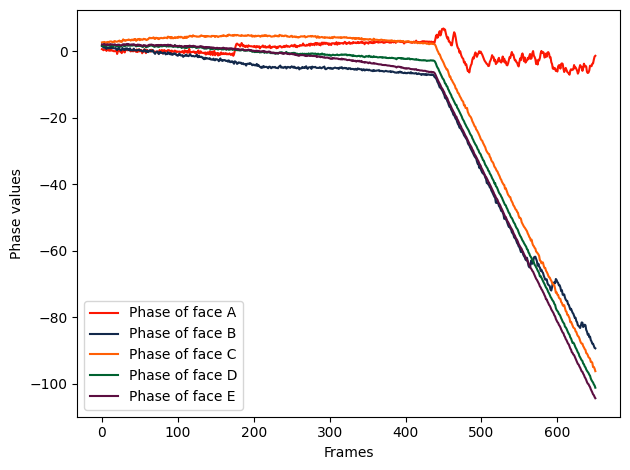

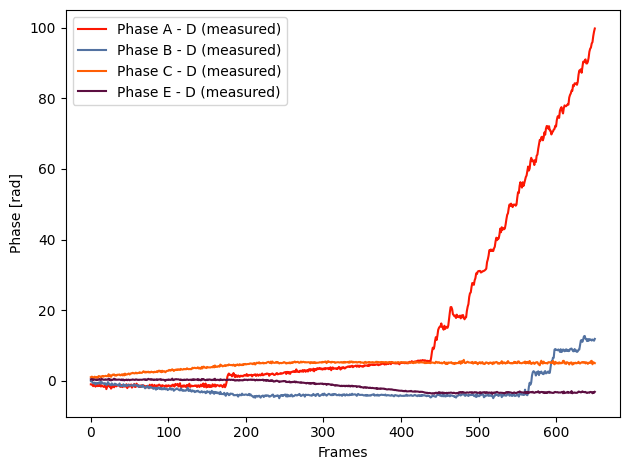

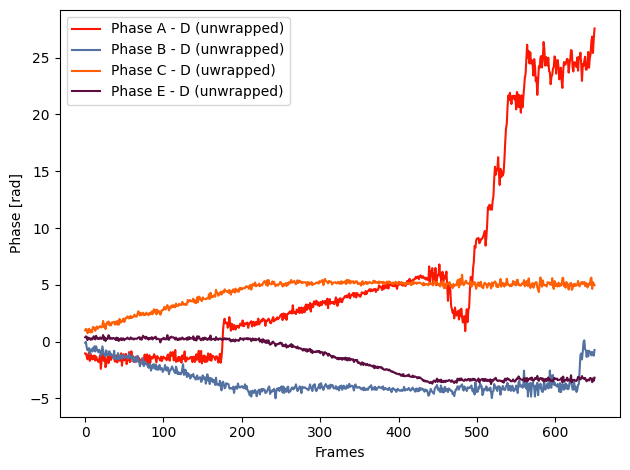

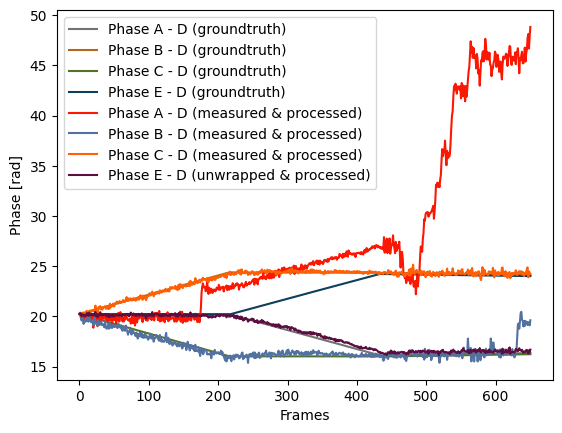

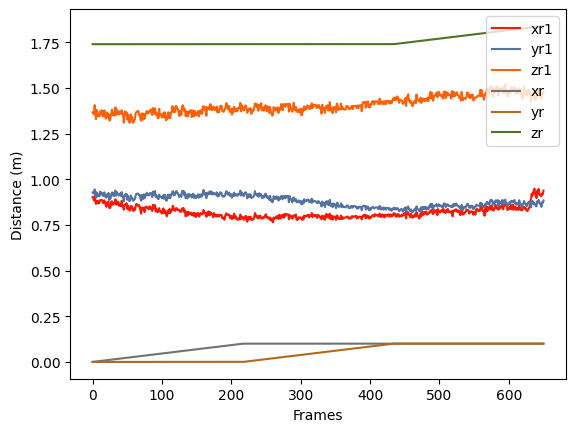

In [11]:
groundtruth_points = [(0,0,1.74), (0.1, 0, 1.74), (0.1, 0.1, 1.74), (0.1, 0.1, 1.84)]

full_processing("3D_angle_20-24GHz.pickle", 651, new_tag, groundtruth_points, 217, initial_guess=[np.pi/2, np.pi/2])

[20.18704632 20.18700048 20.18695457 20.18690858 20.18686253 20.18681641
 20.18677021 20.18672395 20.18667761 20.1866312  20.18658472 20.18653817
 20.18649155 20.18644485 20.18639808 20.18635124 20.18630433 20.18625735
 20.18621029 20.18616316 20.18611596 20.18606868 20.18602133 20.18597391
 20.18592642 20.18587885 20.1858312  20.18578349 20.18573569 20.18568783
 20.18563989 20.18559187 20.18554378 20.18549562 20.18544738 20.18539906
 20.18535067 20.18530221 20.18525367 20.18520505 20.18515635 20.18510758
 20.18505874 20.18500982 20.18496082 20.18491174 20.18486259 20.18481336
 20.18476405 20.18471466 20.1846652  20.18461566 20.18456604 20.18451635
 20.18446657 20.18441672 20.18436679 20.18431678 20.18426669 20.18421652
 20.18416627 20.18411594 20.18406553 20.18401505 20.18396448 20.18391383
 20.18386311 20.1838123  20.18376141 20.18371044 20.18365939 20.18360826
 20.18355705 20.18350575 20.18345438 20.18340292 20.18335138 20.18329976
 20.18324805 20.18319627 20.1831444  20.18309245 20

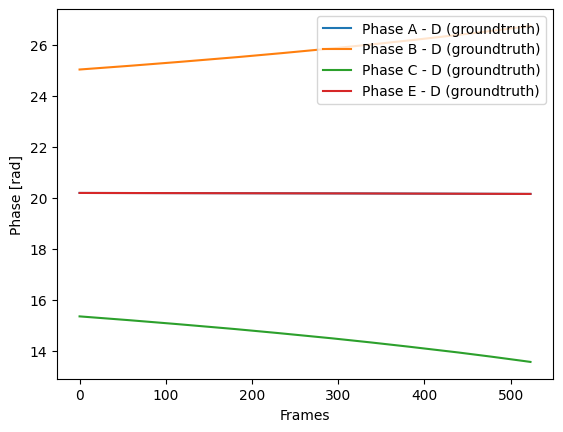

In [15]:
# groundtruth phase viewer

N1 = 131 # per leg
# points = [ (0, 0, 1.5), (0.1, 0, 1.5), (0.1, 0.1, 1.5), (0.1, 0.1, 1.6), (0, 0, 1.5)]
points = [ (0.1, 0, 1.5), (0.1, 0, 1.4), (0.1, 0, 1.3), (0.1, 0, 1.2), (0.1, 0, 1.1)]
d, dhat = generate_groundtruth_path_3d(points, N1)

lam = 3e8/24.15e9
norms = np.linalg.norm(d, axis=1)
vhat = d / norms[:, None]  

## NEW TAG!!!!
a = np.array((0.0, 0.07, -0.020))    # face A (w.r.t. front-face origin) 
b = np.array((-0.072, 0.0, -0.02)) 
c = np.array((0.072, 0.0, -0.02))     # face B
e = np.array((0.0, -0.07, -0.020)) 

# Build radar positions and normalize to unit look vectors
norms = np.linalg.norm(d, axis=1)
vhat = d / norms[:, None]             # tag-origin -> radar

# projections
dr_a = vhat @ a
dr_b = vhat @ b
dr_c = vhat @ c
dr_e = vhat @ e

# Round-trip phase
dphi_a = -(4*np.pi/lam) * dr_a
dphi_b = -(4*np.pi/lam) * dr_b
dphi_c = -(4*np.pi/lam) * dr_c
dphi_e = -(4*np.pi/lam) * dr_e

plt.figure()
plt.plot(dphi_a, label="Phase A - D (groundtruth)")
plt.plot(dphi_b, label="Phase B - D (groundtruth)")
plt.plot(dphi_c, label="Phase C - D (groundtruth)")
plt.plot(dphi_e, label="Phase E - D (groundtruth)")
plt.legend(); plt.xlabel("Frames"); plt.ylabel("Phase [rad]")

print(dphi_a)

data_raw.shape = (32768, 436, 4)


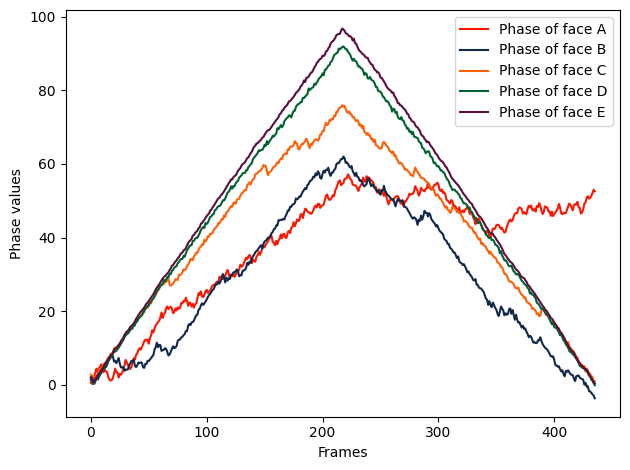

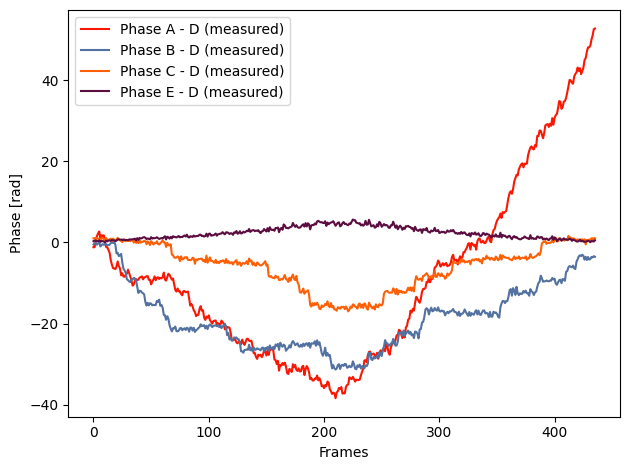

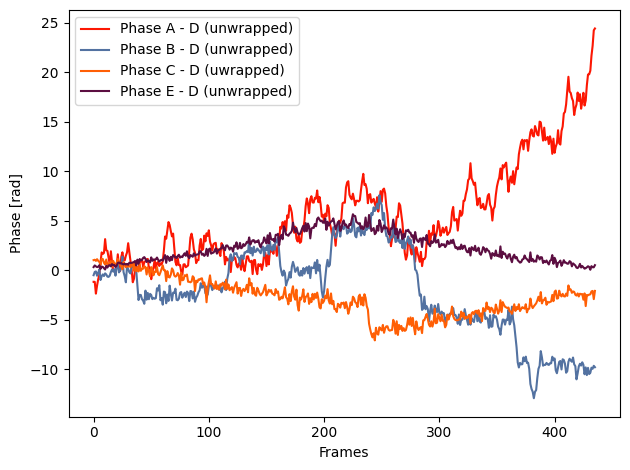

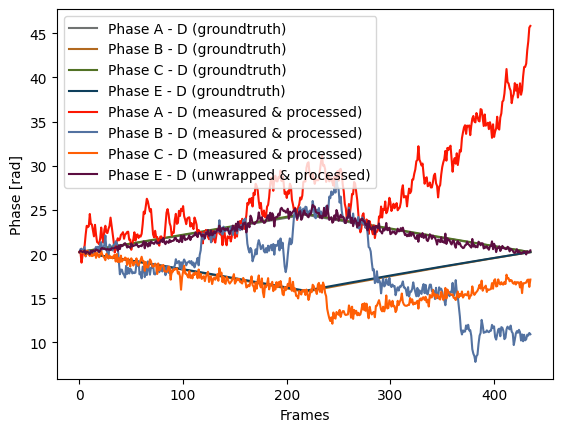

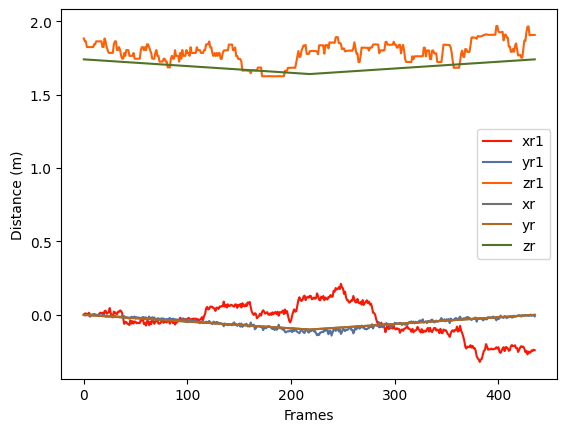

In [53]:
groundtruth_points = [(0,0,1.74), (-0.1,- 0.1, 1.64), (0, 0, 1.74)]

full_processing("3D_angle_25-24GHz.pickle", 436, new_tag, groundtruth_points, 218)

In [42]:
from scipy.optimize import minimize


# a = (0, 0.065, -0.028)                            
# b = (-0.04, 0, -0.02)                             
# c = (0.04, 0, -0.02)
# old_tag = (a, b, c)

## NEW TAG!!!!
a = np.array((0.0, 0.07, -0.020))    # face A (w.r.t. front-face origin) 
b = np.array((-0.072, 0.0, -0.02)) 
c = np.array((0.072, 0.0, -0.02))     # face B
e = np.array((0.0, -0.07, -0.020)) 

new_tag = (a, b, c, e)



def full_processing_vicon(radar_filename, vicon_filename, n_frames=None, tag=new_tag, initial_guess=[np.pi/2, np.pi/2]):



    phaseA, phaseB, phaseC, phaseD, phaseE, ranges = get_all_phases(radar_filename, n_frames)
    plt.figure()
    plt.plot(phaseA, label="Phase of face A", color="#fc1703")
    plt.plot(phaseB, label="Phase of face B", color="#13294B")
    plt.plot(phaseC, label="Phase of face C", color="#FF5F05")
    plt.plot(phaseD, label="Phase of face D", color="#006230")
    plt.plot(phaseE, label="Phase of face E", color="#5C0E41")
    plt.legend()
    plt.xlabel("Frames")
    plt.ylabel("Phase values")
    plt.tight_layout()


    phaseAD = phaseA - phaseD 
    phaseBD = phaseB - phaseD
    phaseCD = phaseC - phaseD
    phaseED = phaseE - phaseD 
    plt.figure()
    plt.plot(phaseAD, label="Phase A - D (measured)", color="#fc1703")
    plt.plot(phaseBD, label="Phase B - D (measured)", color="#5372A1")
    plt.plot(phaseCD, label="Phase C - D (measured)", color="#FF5F05")
    plt.plot(phaseED, label="Phase E - D (measured)", color="#5C0E41")
    plt.legend(); plt.xlabel("Frames"); plt.ylabel("Phase [rad]"); plt.tight_layout()

    # Unwrapping a 2nd time eliminates potential "jumps" in the phase difference data.
    phaseAD = np.unwrap(phaseAD, period=np.pi)
    phaseBD = np.unwrap(phaseBD, period=np.pi)
    phaseCD = np.unwrap(phaseCD, period=np.pi)
    phaseED = np.unwrap(phaseED, period=np.pi)
    plt.figure()
    plt.plot(phaseAD, label="Phase A - D (unwrapped)", color="#fc1703")
    plt.plot(phaseBD, label="Phase B - D (unwrapped)", color="#5372A1")
    plt.plot(phaseCD, label="Phase C - D (uwrapped)", color="#FF5F05")
    plt.plot(phaseED, label="Phase E - D (unwrapped)", color="#5C0E41")
    plt.legend(); plt.xlabel("Frames"); plt.ylabel("Phase [rad]"); plt.tight_layout()

    RADAR_OFFSET = (0, 0, -0.2)

    d, dhat, _, _ = process_vicon(radar_filename, vicon_filename, radar_offset_drone=RADAR_OFFSET)

    lam = 3e8/24.15e9
    norms = np.linalg.norm(d, axis=1)
    vhat = d / norms[:, None]             # tag-origin -> radar

    ## NEW TAG!!!!
    # a = np.array((0.0, 0.07, -0.020))    # face A (w.r.t. front-face origin) 
    # b = np.array((-0.072, 0.0, -0.02)) 
    # c = np.array((0.072, 0.0, -0.02))     # face B
    # e = np.array((0.0, -0.07, -0.020)) 
    a = tag[0]    # face A (w.r.t. front-face origin) 
    b = tag[1]
    c = tag[2]    # face B
    e = tag[3] 

    # projections
    dr_a = vhat @ a
    dr_b = vhat @ b
    dr_c = vhat @ c
    dr_e = vhat @ e

    # Round-trip phase
    dphi_a = -(4*np.pi/lam) * dr_a
    dphi_b = -(4*np.pi/lam) * dr_b
    dphi_c = -(4*np.pi/lam) * dr_c
    dphi_e = -(4*np.pi/lam) * dr_e

    # Assume we know the starting position of the radar. Given this, we can shift each phase difference by the starting amount
    phaseAD = phaseAD + (dphi_a[0] - phaseAD[0])
    phaseBD = phaseBD + (dphi_b[0] - phaseBD[0])
    phaseCD = phaseCD + (dphi_c[0] - phaseCD[0])
    phaseED = phaseED + (dphi_e[0] - phaseED[0])

    # Auto-fix mirroring issue (FIX ME!!!!!)
    [phaseAD, phaseBD, phaseCD, phaseED], signs, errs = flip_phase(
        [phaseAD, phaseBD, phaseCD, phaseED],
        [dphi_a, dphi_b, dphi_c, dphi_e],
        metric="rmse",  # or "mae"
    )

    plt.figure()
    plt.plot(dphi_a, label="Phase A - D (groundtruth)", color="#707372")
    plt.plot(dphi_b, label="Phase B - D (groundtruth)", color="#B2691F")
    plt.plot(dphi_c, label="Phase C - D (groundtruth)", color="#527225")
    plt.plot(dphi_e, label="Phase E - D (groundtruth)", color="#0E3F5C")
    plt.plot(phaseAD, label="Phase A - D (measured & unwrapped)", color="#fc1703")
    plt.plot(phaseBD, label="Phase B - D (measured & unwrapped)", color="#5372A1")
    plt.plot(phaseCD, label="Phase C - D (measured & unwrapped)", color="#FF5F05")
    plt.plot(phaseED, label="Phase E - D (unwrapped & unwrapped)", color="#5C0E41")
    plt.legend(); plt.xlabel("Frames"); plt.ylabel("Phase [rad]")

    # Using A and B
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # x1 = b[0]
    # y2 = a[1]
    # z1 = b[2]
    # z2 = a[2]

    # dr1_array = -(lam/(4*np.pi))*phaseBD
    # dr2_array = -(lam/(4*np.pi))*phaseAD

    # thetas = []
    # phis = []

    # for i in range(len(dr1_array)):
    #     dr1 = dr1_array[i]
    #     dr2 = dr2_array[i]

    #     def f(args):
    #         theta, phi = args
    #         f1 = dr1 - (x1*np.cos(theta)*np.sin(phi) - z1*np.cos(phi))
    #         f2 = dr2 - (y2*np.sin(theta)*np.sin(phi) - z2*np.cos(phi))
    #         return f1**2 + f2**2

    #     # initial guess
    #     # x0 = [np.pi/2, np.pi/2]
    #     x0 = initial_guess

    #     res = minimize(f, x0, method='Nelder-Mead')  # or Nelder-Mead if non-smooth
    #     thetas.append(res.x[0])
    #     phis.append(res.x[1])
    #     # print("Optimal theta, phi:", res.x)
    #     # print("Minimum value:", res.fun)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Using B and E    
    
    x1 = b[0]
    y2 = e[1]
    z1 = b[2]
    z2 = e[2]

    print(x1, y2, z1, z2)

    dr1_array = -(lam/(4*np.pi))*phaseBD
    dr2_array = -(lam/(4*np.pi))*phaseED

    thetas = []
    phis = []

    for i in range(len(dr1_array)):
        dr1 = dr1_array[i]
        dr2 = dr2_array[i]

        def f(args):
            theta, phi = args
            f1 = dr1 - (x1*np.cos(theta)*np.sin(phi) - z1*np.cos(phi))
            f2 = dr2 - (y2*np.sin(theta)*np.sin(phi) - z2*np.cos(phi))
            return f1**2 + f2**2

        # initial guess
        # x0 = [np.pi/2, np.pi/2]
        x0 = initial_guess

        res = minimize(f, x0, method='Nelder-Mead')  # or Nelder-Mead if non-smooth
        thetas.append(res.x[0])
        phis.append(res.x[1])
        # print("Optimal theta, phi:", res.x)
        # print("Minimum value:", res.fun)

    xr1 = ranges*np.cos(thetas)*np.sin(phis)
    yr1 = ranges*np.sin(thetas)*np.sin(phis)
    zr1 = ranges*np.cos(phis)

    #Plotting original and measured 
    plt.figure()
    plt.plot(xr1, label="xr1", color="#fc1703")
    plt.plot(yr1, label='yr1', color="#5372A1")
    plt.plot(np.abs(zr1), label='zr1', color="#FF5F05")
    plt.plot(d[:, 0], label='xr', color="#707372")
    plt.plot(d[:, 1], label='yr', color="#B2691F")
    plt.plot(d[:, 2], label='zr', color="#527225")
    plt.legend()
    plt.xlabel("Frames")
    plt.ylabel("Distance (m)")

    plt.show()


data_raw.shape = (32768, 89, 4)


C:\Users\aplot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


-0.072 -0.07 -0.02 -0.02


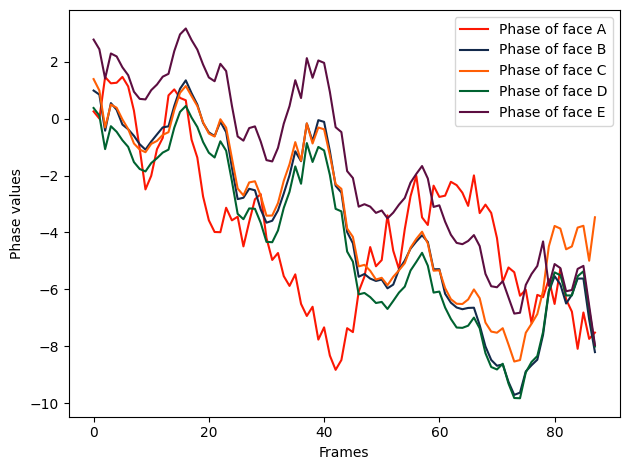

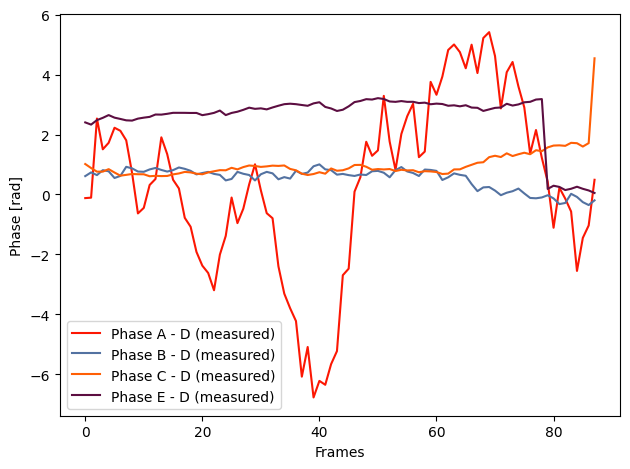

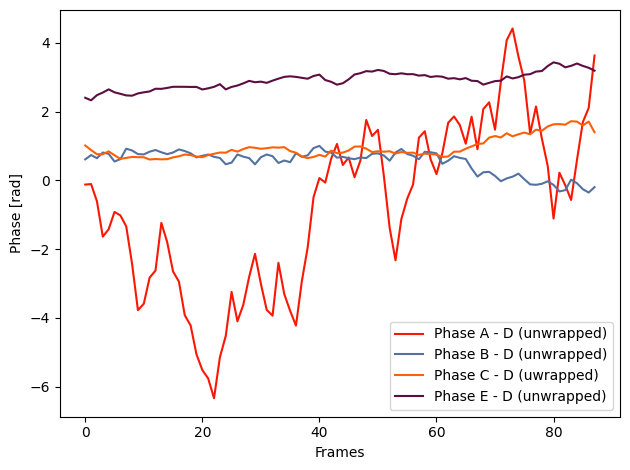

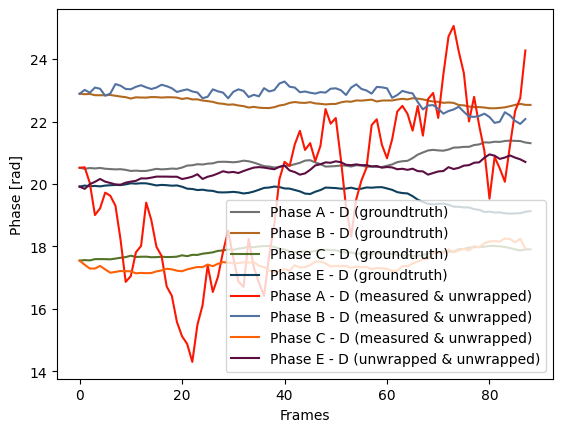

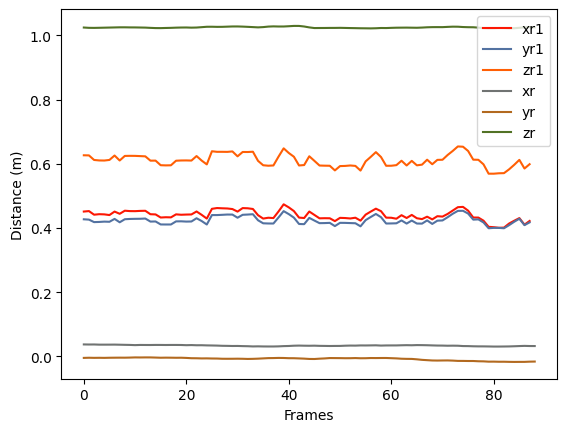

In [43]:
full_processing_vicon("irl_drone_handheld_1-24GHz.pickle", "irl_drone_handheld_1.csv")

data_raw.shape = (32768, 262, 4)
-0.072 -0.07 -0.02 -0.02


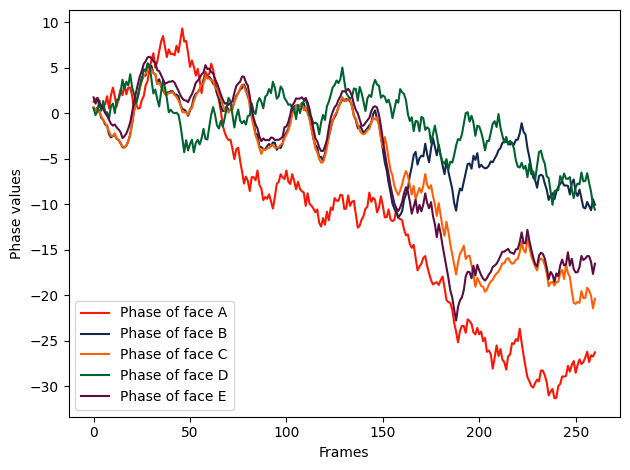

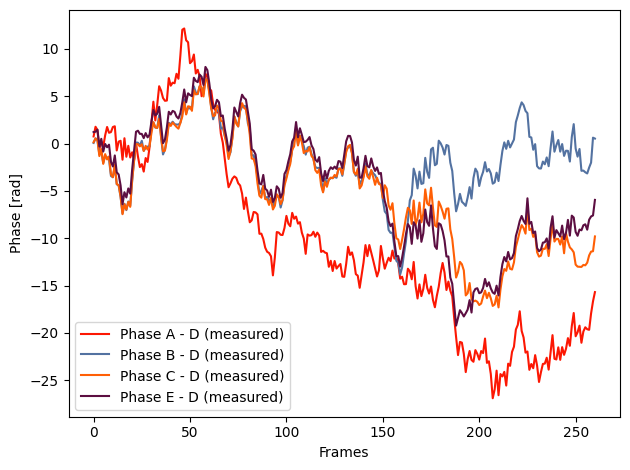

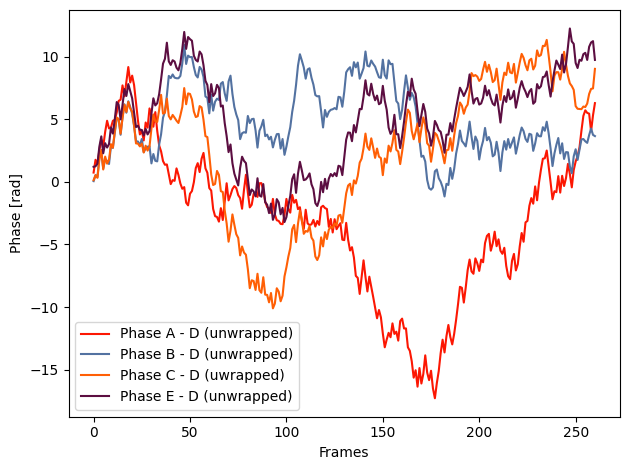

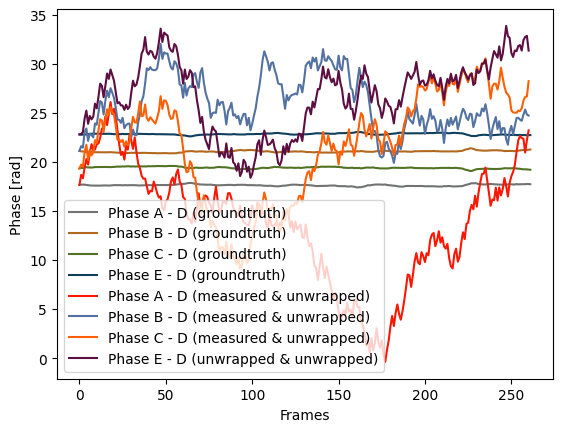

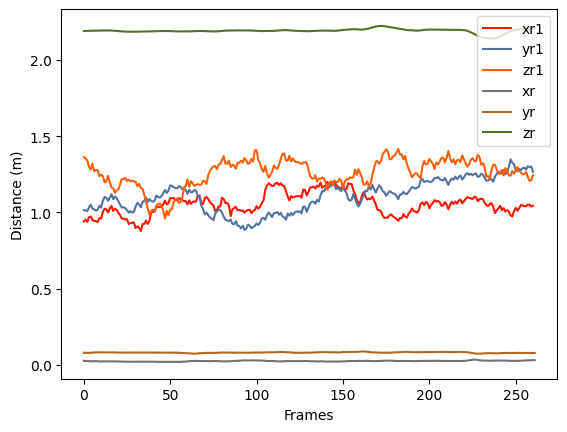

In [45]:
full_processing_vicon("irl_handheld_hover-24GHz.pickle", "irl_handheld_hover.csv")